Importy:

In [2]:
import torch
from torch import nn
import cv2
import numpy as np
import torchvision
import torchvision.transforms as transforms
import optuna
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

Ładowanie danych:

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Pokazanie obrazków:

In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Model i jego warstwy:

In [5]:
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Pokazanie ilości parametrów:

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Ukazanie modelu:

In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

model = Model()
print(model)
print(f"Liczba parametrów modelu: {count_parameters(model)}")

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 136886


Trening:

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
total_correct = 0
total_samples = 0 

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        output_loss = loss(output, labels)
        output_loss.backward()  
        optimizer.step()
        _, predicted = torch.max(output, 1)
        correct = (predicted == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        running_loss += output_loss.item()

    print(f'Epoka [{epoch+1}/{num_epochs}], Strata treningowa: {running_loss/len(trainloader)}')

    if (epoch % 3 == 0):
        model.eval()
        validation_loss = 0.0

        with torch.no_grad():
            for val_images, val_labels in valloader:
                val_output = model(val_images)
                val_loss = loss(val_output, val_labels)
                validation_loss += val_loss.item()

        print(f'Strata walidacyjna po epoce: {validation_loss/len(valloader)}')
        model.train()

print(f'\nWynik dokładności dla mojego modelu dla danych treningowych: {total_correct / total_samples}')


Epoka [1/10], Strata treningowa: 1.5074900605486499
Strata walidacyjna po epoce: 1.2907277737855911
Epoka [2/10], Strata treningowa: 1.2050255196005106
Epoka [3/10], Strata treningowa: 1.0681614307314158
Epoka [4/10], Strata treningowa: 0.9763941591480954
Strata walidacyjna po epoce: 1.0724667567282915
Epoka [5/10], Strata treningowa: 0.9005059866003589
Epoka [6/10], Strata treningowa: 0.8375562121129284
Epoka [7/10], Strata treningowa: 0.7838265806510992
Strata walidacyjna po epoce: 1.1254453417984769
Epoka [8/10], Strata treningowa: 0.7305191632421687
Epoka [9/10], Strata treningowa: 0.6924083313173045
Epoka [10/10], Strata treningowa: 0.6489842686807504
Strata walidacyjna po epoce: 1.223310985195823

Wynik dokładności dla mojego modelu dla danych treningowych: 0.6670777777777778


Dla zbioru danych testowych:

In [11]:
model.eval()

test_correct = 0
test_samples = 0 

for images, labels in testloader:
    optimizer.zero_grad()
    output = model(images)
    optimizer.step()
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    test_correct += correct
    test_samples += labels.size(0)


print(f'\nWynik dokładności dla mojego modelu dla danych testowych: {test_correct / test_samples}')


Wynik dokładności dla mojego modelu dla danych testowych: 0.6342


Parametryzowalny model:

In [10]:
class Model_Custom(nn.Module):
    def __init__(self, layers, input_size=(32, 32)) -> None:
        super(Model_Custom, self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(layers[i]["entry"], layers[i]["out"], kernel_size=layers[i]["kernel_size"], stride=1, padding=2) for i in range(len(layers))])
        self.pool = nn.AvgPool2d(2, 2)

        self.fc1 = None
        # final_size = self._calculate_output_size(input_size[0], len(layers), layers)
        # self.fc1 = nn.Linear(final_size * final_size * layers[-1]["out"], 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc_last = nn.Linear(84, 10)

    def _calculate_output_size(self, input_size, n_layers, layers):
        size = input_size
        for i in range(n_layers):
            size = (size + 2 * 2 - layers[i]["kernel_size"]) // 1 + 1
            size = size // 2
        return size

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(conv(x))
            x = self.pool(x)

        x = torch.flatten(x, 1)

        if self.fc1 is None:
            in_features = x.size(1)
            self.fc1 = nn.Linear(in_features, 120)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_last(x)

        return x

Customizowalny model:

In [ ]:
def custom_net(lerning_late, layers, num_epochs):
    model = Model_Custom(layers)
    print(model)
    print(f"Liczba parametrów modelu: {count_parameters(model)}")

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lerning_late)
    total_correct = 0
    total_samples = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model(images)
            output_loss = loss(output, labels)
            output_loss.backward()  
            optimizer.step()
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            running_loss += output_loss.item()

        print(f'Epoka [{epoch+1}/{num_epochs}], Strata treningowa: {running_loss/len(trainloader)}')

        if (epoch % 3 == 0):
            model.eval()
            validation_loss = 0.0

            with torch.no_grad():
                for val_images, val_labels in valloader:
                    val_output = model(val_images)
                    val_loss = loss(val_output, val_labels)
                    validation_loss += val_loss.item()

            print(f'Strata walidacyjna po epoce: {validation_loss/len(valloader)}')
            model.train()

    print(f'\nWynik dokładności dla mojego modelu dla danych treningowych: {total_correct / total_samples}')

    model.eval()

    test_correct = 0
    test_samples = 0 

    with torch.no_grad():
        for images, labels in testloader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            test_correct += correct
            test_samples += labels.size(0)

    return test_correct / test_samples

Wywołanie:

In [26]:
layers = [
    {"entry": 3, "out": 6, "kernel_size": 5},
    {"entry": 6, "out": 16, "kernel_size": 5}
]

accaccuracy = custom_net(0.001, layers, 10)

print(f'\nWynik dokładności dla mojego modelu z customowymi parametrami dla danych testowych: {accaccuracy}')

Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 13886
Epoka [1/10], Strata treningowa: 1.6325626681804657
Strata walidacyjna po epoce: 1.5027908665180207
Epoka [2/10], Strata treningowa: 1.4289755011532042
Epoka [3/10], Strata treningowa: 1.3545746428926786
Epoka [4/10], Strata treningowa: 1.3102068643715648
Strata walidacyjna po epoce: 1.3624903577983378
Epoka [5/10], Strata treningowa: 1.2704350065979693
Epoka [6/10], Strata treningowa: 1.2421796751028962
Epoka [7/10], Strata treningowa: 1.2168171568140387
Strata walidacyjna po epoce: 1.3252484933674336
Epoka [8/10], Strata treningowa: 1.1970571238186625
Epoka [9/10], Strata treningowa: 1.18

Szukanie hiperparametrów:

In [27]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    n_layers = trial.suggest_int('n_layers', 2, 5)
    conv_out = trial.suggest_int('conv_out', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 1, 5, step=2)

    layers = [
        {"entry": 3, "out": conv_out, "kernel_size": kernel_size}
    ]
    for _ in range(n_layers - 1):
        layers.append({"entry": conv_out, "out": conv_out, "kernel_size": kernel_size})

    accuracy = custom_net(lr, layers, num_epochs=10)

    return accuracy

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Najlepsze hiperparametry: ", study.best_params)

[I 2024-10-24 14:29:46,439] A new study created in memory with name: no-name-d53ce513-cfbf-4c67-a744-6b97a33f9172
C:\Users\Mateusz\AppData\Local\Temp\ipykernel_3548\405360016.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 240166
Epoka [1/10], Strata treningowa: 1.7454734951814015
Strata walidacyjna po epoce: 1.5694284559488296
Epoka [2/10], Strata treningowa: 1.4674640503883363
Epoka [3/10], Strata treningowa: 1.3445630356642935
Epoka [4/10], Strata treningowa: 1.2606209529088603
Strata walidacyjna po epoce: 1.2660106965065003
Epoka [5/10], Strata treningowa: 1.1948280248850585
Epoka [6/10], Strata treningowa: 1.136150265571144
Epoka [7/10], Strata treningowa: 1.0861038734777106
Strata walidacyjna po epoce: 1.1136575412869454
Epoka [8/10], Strata treningowa: 1.037539607566264
Epoka [9/10], Strata trenin

[I 2024-10-24 14:39:59,805] Trial 0 finished with value: 0.6466 and parameters: {'lr': 0.00010143819035635126, 'n_layers': 3, 'conv_out': 112, 'kernel_size': 3}. Best is trial 0 with value: 0.6466.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 243974
Epoka [1/10], Strata treningowa: 1.8741868538485633
Strata walidacyjna po epoce: 1.737463948059082
Epoka [2/10], Strata treningowa: 1.5836104803535673
Epoka [3/10], Strata treningowa: 1.453301278327571
Epoka [4/10], Strata treningowa: 1.3603646741721365
Strata walidacyjna po epoce: 1.3358355244636535
Epoka [5/10], Strata treningowa: 1.2827120516134634
Epoka [6/10], Strata treningowa: 1.2130436745233006
Epoka [7/10], Strata treningowa: 1.14946362847156
Strata walidacyjna po epoce: 1.1393958956420422
Epoka [8/10], Strata treningowa: 1.090080336607496
Epoka [9/10], Strata treningowa: 

[I 2024-10-24 14:49:26,147] Trial 1 finished with value: 0.6397 and parameters: {'lr': 0.00011268202500741872, 'n_layers': 5, 'conv_out': 80, 'kernel_size': 3}. Best is trial 0 with value: 0.6466.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 74710
Epoka [1/10], Strata treningowa: 1.6318000225822131
Strata walidacyjna po epoce: 1.3861239825367928
Epoka [2/10], Strata treningowa: 1.2671061653183566
Epoka [3/10], Strata treningowa: 1.0993060731046729
Epoka [4/10], Strata treningowa: 0.9830650430240565
Strata walidacyjna po epoce: 0.9735217805281281
Epoka [5/10], Strata treningowa: 0.8914548373346527
Epoka [6/10], Strata treningowa: 0.8217993717779716
Epoka [7/10], Strata treningowa: 0.7606800521505376
Strata walidacyjna po epoce: 0.8697535689627752
Epoka [8/10], Strata treningowa: 0.7121282049265173
Epoka [9/10], Strata treningo

[I 2024-10-24 14:56:00,016] Trial 2 finished with value: 0.7228 and parameters: {'lr': 0.0006563429051190292, 'n_layers': 4, 'conv_out': 48, 'kernel_size': 3}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 479302
Epoka [1/10], Strata treningowa: 1.5099589594284692
Strata walidacyjna po epoce: 1.243891344898939
Epoka [2/10], Strata treningowa: 1.1595247326834335
Epoka [3/10], Strata treningowa: 1.010072269544171
Epoka [4/10], Strata treningowa: 0.9075255134181223
Strata walidacyjna po epoce: 0.9818330199766904
Epoka [5/10], Strata treningowa: 0.8261875429627796
Epoka [6/10], Strata treningowa: 0.766333394723101
Epoka [7/10], Strata treningowa: 0.7079422797922122
Strata walidacyjna po epoce: 0.9049576090652496
Epoka [8/10], Strata treningowa: 0.6581637147196207
Epoka [9/10], Strata treningowa

[I 2024-10-24 15:07:36,358] Trial 3 finished with value: 0.6956 and parameters: {'lr': 0.0010237011214945877, 'n_layers': 3, 'conv_out': 96, 'kernel_size': 5}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 123590
Epoka [1/10], Strata treningowa: 1.8086981124666002
Strata walidacyjna po epoce: 1.6383831911563873
Epoka [2/10], Strata treningowa: 1.5684308673090406
Epoka [3/10], Strata treningowa: 1.4424640851140023
Epoka [4/10], Strata treningowa: 1.3513241511291927
Strata walidacyjna po epoce: 1.3206543737888337
Epoka [5/10], Strata treningowa: 1.2786445554852486
Epoka [6/10], Strata treningowa: 1.2158422282000383
Epoka [7/10], Strata treningowa: 1.1632175943546825
Strata walidacyjna po epoce: 1.1990242166399956
Epoka [8/10], Strata treningowa: 1.1157138848652441
Epoka [9/10], Strata trening

[I 2024-10-24 15:14:55,683] Trial 4 finished with value: 0.6254 and parameters: {'lr': 0.00012003847018675302, 'n_layers': 4, 'conv_out': 64, 'kernel_size': 3}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 16102
Epoka [1/10], Strata treningowa: 1.8559347128550212
Strata walidacyjna po epoce: 1.733749787759781
Epoka [2/10], Strata treningowa: 1.7294070784807205
Epoka [3/10], Strata treningowa: 1.6938529605468113
Epoka [4/10], Strata treningowa: 1.6662689923710294
Strata walidacyjna po epoce: 1.7085443233728408
Epoka [5/10], Strata treningowa: 1.6492031017541886
Epoka [6/10], Strata treningowa: 1.6459998306393624
Epoka [7/10], Strata treningowa: 1.6377522967179616
Strata walidacyjna po epoce: 1.6946823536157607
Epoka [8/10], Strata treningowa: 1.6391847740226322
Epoka [9/10], Strata treningow

[I 2024-10-24 15:19:22,480] Trial 5 finished with value: 0.3881 and parameters: {'lr': 0.009875864229059743, 'n_layers': 3, 'conv_out': 16, 'kernel_size': 3}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 11894
Epoka [1/10], Strata treningowa: 2.045478460963567
Strata walidacyjna po epoce: 1.9694999514102935
Epoka [2/10], Strata treningowa: 1.8936079549206628
Epoka [3/10], Strata treningowa: 1.817607074769338
Epoka [4/10], Strata treningowa: 1.7768638203965292
Strata walidacyjna po epoce: 1.7811098039627076
Epoka [5/10], Strata treningowa: 1.7499998675372865
Epoka [6/10], Strata treningowa: 1.727816850540373
Epoka [7/10], Strata treningowa: 1.7088928550216886
Strata walidacyjna po epoce: 1.7134653786182403
Epoka [8/10], Strata treningowa: 1.692670890900824
Epoka [9/10], Strata treningowa: 

[I 2024-10-24 15:24:10,625] Trial 6 finished with value: 0.4076 and parameters: {'lr': 0.00027670456399496484, 'n_layers': 4, 'conv_out': 16, 'kernel_size': 1}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 709798
Epoka [1/10], Strata treningowa: 1.9669580615202586
Strata walidacyjna po epoce: 1.8609989902019501
Epoka [2/10], Strata treningowa: 1.7959428497897254
Epoka [3/10], Strata treningowa: 1.720390819480684
Epoka [4/10], Strata treningowa: 1.6705746939526664
Strata walidacyjna po epoce: 1.655841153907776
Epoka [5/10], Strata treningowa: 1.625913265238868
Epoka [6/10], Strata treningowa: 1.5869340513361825
Epoka [7/10], Strata treningowa: 1.5507136482477188
Strata walidacyjna po epoce: 1.5552743984699249
Epoka [8/10], Strata treningowa: 1.520257308157285
Epoka [9/10], Strata treningowa:

[I 2024-10-24 15:36:22,062] Trial 7 finished with value: 0.472 and parameters: {'lr': 1.027682713387195e-05, 'n_layers': 4, 'conv_out': 96, 'kernel_size': 5}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 37894
Epoka [1/10], Strata treningowa: 2.1333379267268713
Strata walidacyjna po epoce: 2.056286244392395
Epoka [2/10], Strata treningowa: 2.006883700328403
Epoka [3/10], Strata treningowa: 1.9414705910152859
Epoka [4/10], Strata treningowa: 1.888640539206399
Strata walidacyjna po epoce: 1.8781769868850708
Epoka [5/10], Strata treningowa: 1.84243581633038
Epoka [6/10], Strata treningowa: 1.8133981151368883
Epoka [7/10], Strata treningowa: 1.7937051557752821
Strata walidacyjna po epoce: 1.8107218222141266
Epoka [8/10], Strata treningowa: 1.7774763719876607
Epoka [9/10], Strata treningowa: 1

[I 2024-10-24 15:42:14,430] Trial 8 finished with value: 0.3474 and parameters: {'lr': 2.3430026289740978e-05, 'n_layers': 5, 'conv_out': 16, 'kernel_size': 5}. Best is trial 2 with value: 0.7228.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 95494
Epoka [1/10], Strata treningowa: 1.6802333391997548
Strata walidacyjna po epoce: 1.434176861691475
Epoka [2/10], Strata treningowa: 1.334117326174842
Epoka [3/10], Strata treningowa: 1.1461843353748322
Epoka [4/10], Strata treningowa: 1.0226108544086416
Strata walidacyjna po epoce: 1.0132465562328696
Epoka [5/10], Strata treningowa: 0.9264096184483833
Epoka [6/10], Strata treningowa: 0.845708187786407
Epoka [7/10], Strata treningowa: 0.7830392151269234
Strata walidacyjna po epoce: 0.8401846417039632
Epoka [8/10], Strata treningowa: 0.7239458499847601
Epoka [9/10], Strata treningowa:

[I 2024-10-24 15:49:32,099] Trial 9 finished with value: 0.7247 and parameters: {'lr': 0.0005539361207466788, 'n_layers': 5, 'conv_out': 48, 'kernel_size': 3}. Best is trial 9 with value: 0.7247.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 13558
Epoka [1/10], Strata treningowa: 1.7056439922147326
Strata walidacyjna po epoce: 1.6536541638612747
Epoka [2/10], Strata treningowa: 1.5618726715485254
Epoka [3/10], Strata treningowa: 1.5151714123129845
Epoka [4/10], Strata treningowa: 1.4886957363771067
Strata walidacyjna po epoce: 1.612344684290886
Epoka [5/10], Strata treningowa: 1.4712251934753524
Epoka [6/10], Strata treningowa: 1.4548087969289885
Epoka [7/10], Strata treningowa: 1.442665681608518
Strata walidacyjna po epoce: 1.5130408646702767
Epoka [8/10], Strata treningowa: 1.4357222299112213
Epoka [9/10], Strata treningowa: 1.42

[I 2024-10-24 15:54:25,942] Trial 10 finished with value: 0.4709 and parameters: {'lr': 0.0033127230301659046, 'n_layers': 2, 'conv_out': 48, 'kernel_size': 1}. Best is trial 9 with value: 0.7247.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 20614
Epoka [1/10], Strata treningowa: 1.9860317950619593
Strata walidacyjna po epoce: 1.9567378371238708
Epoka [2/10], Strata treningowa: 1.858194554037518
Epoka [3/10], Strata treningowa: 1.7748237617015838
Epoka [4/10], Strata treningowa: 1.715762656349606
Strata walidacyjna po epoce: 1.742421763586998
Epoka [5/10], Strata treningowa: 1.6824954154332479
Epoka [6/10], Strata treningowa: 1.6572484638108147
Epoka [7/10], Strata treningowa: 1.6349934254169465
Strata walidacyjna po epoce: 1.6690924050331115
Epoka [8/10], Strata treningowa: 1.6140672245780627
Epoka [9/10], Strata treningowa:

[I 2024-10-24 16:01:09,289] Trial 11 finished with value: 0.4372 and parameters: {'lr': 0.0009533564133593521, 'n_layers': 5, 'conv_out': 48, 'kernel_size': 1}. Best is trial 9 with value: 0.7247.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 95494
Epoka [1/10], Strata treningowa: 1.6776004874957933
Strata walidacyjna po epoce: 1.448519480752945
Epoka [2/10], Strata treningowa: 1.3065392182423008
Epoka [3/10], Strata treningowa: 1.1349103365474278
Epoka [4/10], Strata treningowa: 1.0105628633866708
Strata walidacyjna po epoce: 1.0805600738301873
Epoka [5/10], Strata treningowa: 0.9202563055694103
Epoka [6/10], Strata treningowa: 0.8493617946229876
Epoka [7/10], Strata treningowa: 0.7877971989766591
Strata walidacyjna po epoce: 0.8528186394814402
Epoka [8/10], Strata treningowa: 0.7387139402177185
Epoka [9/10], Strata treningow

[I 2024-10-24 16:08:24,931] Trial 12 finished with value: 0.7214 and parameters: {'lr': 0.0008464499382640642, 'n_layers': 5, 'conv_out': 48, 'kernel_size': 3}. Best is trial 9 with value: 0.7247.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 123590
Epoka [1/10], Strata treningowa: 1.619211789751053
Strata walidacyjna po epoce: 1.455256283724308
Epoka [2/10], Strata treningowa: 1.271817446195417
Epoka [3/10], Strata treningowa: 1.1061695217774974
Epoka [4/10], Strata treningowa: 0.9864240883377691
Strata walidacyjna po epoce: 0.9752540271162987
Epoka [5/10], Strata treningowa: 0.890536716277649
Epoka [6/10], Strata treningowa: 0.8152897959426045
Epoka [7/10], Strata treningowa: 0.7479557908264506
Strata walidacyjna po epoce: 0.79975136179775
Epoka [8/10], Strata treningowa: 0.6907806066057748
Epoka [9/10], Strata treningowa: 0

[I 2024-10-24 16:15:55,523] Trial 13 finished with value: 0.7373 and parameters: {'lr': 0.00046434187070760514, 'n_layers': 4, 'conv_out': 64, 'kernel_size': 3}. Best is trial 13 with value: 0.7373.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 77574
Epoka [1/10], Strata treningowa: 1.943661880376604
Strata walidacyjna po epoce: 1.9002242376804352
Epoka [2/10], Strata treningowa: 1.7970043550597297
Epoka [3/10], Strata treningowa: 1.73329579472012
Epoka [4/10], Strata treningowa: 1.7003881055540508
Strata walidacyjna po epoce: 1.7142027740716934
Epoka [5/10], Strata treningowa: 1.6700648134920333
Epoka [6/10], Strata treningowa: 1.6453736192809212
Epoka [7/10], Strata treningowa: 1.6241408793793783
Strata walidacyjna po epoce: 1.6617944264411926
Epoka [8/10], Strata treningowa: 1.6031534031099743
Epoka [9/10], Strata treningo

[I 2024-10-24 16:26:20,803] Trial 14 finished with value: 0.429 and parameters: {'lr': 0.0028388030868808315, 'n_layers': 5, 'conv_out': 128, 'kernel_size': 1}. Best is trial 13 with value: 0.7373.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 323270
Epoka [1/10], Strata treningowa: 1.5838437097668647
Strata walidacyjna po epoce: 1.31433412348032
Epoka [2/10], Strata treningowa: 1.1876121116373275
Epoka [3/10], Strata treningowa: 0.9892771530760659
Epoka [4/10], Strata treningowa: 0.8520239819185601
Strata walidacyjna po epoce: 0.8411208393529057
Epoka [5/10], Strata treningowa: 0.7442990399745577
Epoka [6/10], Strata treningowa: 0.6565277408439485
Epoka [7/10], Strata treningowa: 0.5807111259910045
Strata walidacyjna po epoce: 0.7049962358307094
Epoka [8/10], Strata treningowa: 0.5157972099381384
Epoka [9/10], Strata treningow

[I 2024-10-24 16:34:57,912] Trial 15 finished with value: 0.758 and parameters: {'lr': 0.0003275478547485174, 'n_layers': 4, 'conv_out': 64, 'kernel_size': 5}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(80, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 177174
Epoka [1/10], Strata treningowa: 1.61388285015689
Strata walidacyjna po epoce: 1.4611972734928131
Epoka [2/10], Strata treningowa: 1.3449015722168816
Epoka [3/10], Strata treningowa: 1.2385386545677979
Epoka [4/10], Strata treningowa: 1.159650565420919
Strata walidacyjna po epoce: 1.1981572269320488
Epoka [5/10], Strata treningowa: 1.0955925101286834
Epoka [6/10], Strata treningowa: 1.0408601144540641
Epoka [7/10], Strata treningowa: 0.993948008117742
Strata walidacyjna po epoce: 1.0758712421894074
Epoka [8/10], Strata treningowa: 0.9550093769740727
Epoka [9/10], Strata treningowa: 0.918

[I 2024-10-24 16:42:58,173] Trial 16 finished with value: 0.6481 and parameters: {'lr': 0.00024486155761967274, 'n_layers': 2, 'conv_out': 80, 'kernel_size': 5}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 323270
Epoka [1/10], Strata treningowa: 1.8224061352994707
Strata walidacyjna po epoce: 1.7211089388132095
Epoka [2/10], Strata treningowa: 1.5689126659711201
Epoka [3/10], Strata treningowa: 1.4590091175542936
Epoka [4/10], Strata treningowa: 1.3747940257257885
Strata walidacyjna po epoce: 1.4087283687829972
Epoka [5/10], Strata treningowa: 1.2935330103211933
Epoka [6/10], Strata treningowa: 1.218490552789635
Epoka [7/10], Strata treningowa: 1.1506964662227366
Strata walidacyjna po epoce: 1.1340856690883636
Epoka [8/10], Strata treningowa: 1.091503902087609
Epoka [9/10], Strata treningow

[I 2024-10-24 16:51:17,168] Trial 17 finished with value: 0.6422 and parameters: {'lr': 5.744697064368321e-05, 'n_layers': 4, 'conv_out': 64, 'kernel_size': 5}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 64710
Epoka [1/10], Strata treningowa: 1.726404450477494
Strata walidacyjna po epoce: 1.6224047280311584
Epoka [2/10], Strata treningowa: 1.537009518500169
Epoka [3/10], Strata treningowa: 1.47298431501521
Epoka [4/10], Strata treningowa: 1.4181221810089217
Strata walidacyjna po epoce: 1.416572156882286
Epoka [5/10], Strata treningowa: 1.3651809747722414
Epoka [6/10], Strata treningowa: 1.3171577188379235
Epoka [7/10], Strata treningowa: 1.2724214082668226
Strata walidacyjna po epoce: 1.252861666804552
Epoka [8/10], Strata treningowa: 1.2364502461330757
Epoka [9/10], Strata treningowa: 1.

[I 2024-10-24 16:56:28,066] Trial 18 finished with value: 0.5614 and parameters: {'lr': 0.0026543549951504554, 'n_layers': 3, 'conv_out': 32, 'kernel_size': 5}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 262822
Epoka [1/10], Strata treningowa: 1.6033007426473829
Strata walidacyjna po epoce: 1.3606264086723328
Epoka [2/10], Strata treningowa: 1.24467583265437
Epoka [3/10], Strata treningowa: 1.067891506349047
Epoka [4/10], Strata treningowa: 0.9478333749921786
Strata walidacyjna po epoce: 0.9464500913858414
Epoka [5/10], Strata treningowa: 0.8485373514658875
Epoka [6/10], Strata treningowa: 0.7739834627554545
Epoka [7/10], Strata treningowa: 0.7059402529635053
Strata walidacyjna po epoce: 0.8195505285620689
Epoka [8/10], Strata treningowa: 0.648383188162475
Epoka [9/10], Strata treningowa:

[I 2024-10-24 17:05:53,955] Trial 19 finished with value: 0.7433 and parameters: {'lr': 0.0003294559505602095, 'n_layers': 4, 'conv_out': 96, 'kernel_size': 3}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 479302
Epoka [1/10], Strata treningowa: 1.8132285944779714
Strata walidacyjna po epoce: 1.6571880141735076
Epoka [2/10], Strata treningowa: 1.5525190848085615
Epoka [3/10], Strata treningowa: 1.4404561604910426
Epoka [4/10], Strata treningowa: 1.3675172858688567
Strata walidacyjna po epoce: 1.3713354489564895
Epoka [5/10], Strata treningowa: 1.3143318018496037
Epoka [6/10], Strata treningowa: 1.2670518246697056
Epoka [7/10], Strata treningowa: 1.223728012365765
Strata walidacyjna po epoce: 1.2483127687573432
Epoka [8/10], Strata treningowa: 1.1808496194905704
Epoka [9/10], Strata treningo

[I 2024-10-24 18:30:32,121] Trial 20 finished with value: 0.598 and parameters: {'lr': 3.595260844822617e-05, 'n_layers': 3, 'conv_out': 96, 'kernel_size': 5}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 186294
Epoka [1/10], Strata treningowa: 1.6158595750835207
Strata walidacyjna po epoce: 1.3980476068019867
Epoka [2/10], Strata treningowa: 1.28500499495599
Epoka [3/10], Strata treningowa: 1.1261977045837377
Epoka [4/10], Strata treningowa: 1.0096919651541445
Strata walidacyjna po epoce: 0.9853082850635052
Epoka [5/10], Strata treningowa: 0.914152674288551
Epoka [6/10], Strata treningowa: 0.838125578699592
Epoka [7/10], Strata treningowa: 0.7741680820643695
Strata walidacyjna po epoce: 0.8822716104537248
Epoka [8/10], Strata treningowa: 0.7161953760366887
Epoka [9/10], Strata treningowa:

[I 2024-10-24 18:39:12,915] Trial 21 finished with value: 0.7174 and parameters: {'lr': 0.00030983301651348635, 'n_layers': 4, 'conv_out': 80, 'kernel_size': 3}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 123590
Epoka [1/10], Strata treningowa: 1.7540822641876008
Strata walidacyjna po epoce: 1.5845282210111618
Epoka [2/10], Strata treningowa: 1.4892088274584876
Epoka [3/10], Strata treningowa: 1.3523563024202983
Epoka [4/10], Strata treningowa: 1.2540115782121817
Strata walidacyjna po epoce: 1.2450853363633156
Epoka [5/10], Strata treningowa: 1.1723790568828583
Epoka [6/10], Strata treningowa: 1.106622950479057
Epoka [7/10], Strata treningowa: 1.0508295224939783
Strata walidacyjna po epoce: 1.0742269305542111
Epoka [8/10], Strata treningowa: 1.000261934032374
Epoka [9/10], Strata treningow

[I 2024-10-24 18:46:51,234] Trial 22 finished with value: 0.6492 and parameters: {'lr': 0.00016406698877034778, 'n_layers': 4, 'conv_out': 64, 'kernel_size': 3}. Best is trial 15 with value: 0.758.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 353174
Epoka [1/10], Strata treningowa: 1.5579418525550102
Strata walidacyjna po epoce: 1.3492040729641914
Epoka [2/10], Strata treningowa: 1.180829980435305
Epoka [3/10], Strata treningowa: 0.9937647968293064
Epoka [4/10], Strata treningowa: 0.864323211216016
Strata walidacyjna po epoce: 0.9093719008021056
Epoka [5/10], Strata treningowa: 0.7660772526662797
Epoka [6/10], Strata treningowa: 0.685502732180742
Epoka [7/10], Strata treningowa: 0.6135261049128138
Strata walidacyjna po epoce: 0.6986903945699334
Epoka [8/10], Strata treningowa: 0.5546069539141635
Epoka [9/10], Strata trening

[I 2024-10-24 18:59:11,887] Trial 23 finished with value: 0.7618 and parameters: {'lr': 0.00045352634303509143, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 61062
Epoka [1/10], Strata treningowa: 1.8356378408193588
Strata walidacyjna po epoce: 1.703606545162201
Epoka [2/10], Strata treningowa: 1.6515846430593066
Epoka [3/10], Strata treningowa: 1.5808323594596652
Epoka [4/10], Strata treningowa: 1.5410522243181863
Strata walidacyjna po epoce: 1.5843410361528396
Epoka [5/10], Strata treningowa: 1.512691990492079
Epoka [6/10], Strata treningowa: 1.489248692995972
Epoka [7/10], Strata treningowa: 1.4679557442678346
Strata walidacyjna po epoce: 1.5060900191783906
Epoka [8/10], Strata treningowa: 1.4498660943918757
Epoka [9/10], Strata treningo

[I 2024-10-24 19:09:25,188] Trial 24 finished with value: 0.4782 and parameters: {'lr': 0.0017292022550697771, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 1}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 240166
Epoka [1/10], Strata treningowa: 1.6053217434830136
Strata walidacyjna po epoce: 1.423397826051712
Epoka [2/10], Strata treningowa: 1.3047877529627747
Epoka [3/10], Strata treningowa: 1.1677334321624704
Epoka [4/10], Strata treningowa: 1.0609747550568647
Strata walidacyjna po epoce: 1.042313637304306
Epoka [5/10], Strata treningowa: 0.9791031241748068
Epoka [6/10], Strata treningowa: 0.9097289976838562
Epoka [7/10], Strata treningowa: 0.8542530777424574
Strata walidacyjna po epoce: 0.8920591451495886
Epoka [8/10], Strata treningowa: 0.7994755551721694
Epoka [9/10], Strata trenin

[I 2024-10-24 19:20:13,376] Trial 25 finished with value: 0.7022 and parameters: {'lr': 0.00021353312920846597, 'n_layers': 3, 'conv_out': 112, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(112, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 960662
Epoka [1/10], Strata treningowa: 1.5808649455706278
Strata walidacyjna po epoce: 1.2867586978197099
Epoka [2/10], Strata treningowa: 1.1604172626278466
Epoka [3/10], Strata treningowa: 0.9468351910925987
Epoka [4/10], Strata treningowa: 0.8006741922471827
Strata walidacyjna po epoce: 0.8375020239565522
Epoka [5/10], Strata treningowa: 0.6873042040530593
Epoka [6/10], Strata treningowa: 0.5955681058992425
Epoka [7/10], Strata treningowa: 0.5115750509947564
Strata walidacyjna po epoce: 0.7549368641014211
Epoka [8/10], Strata treningowa: 0.4345919398734747
Epoka [9/10], Strata tren

[I 2024-10-24 19:37:22,226] Trial 26 finished with value: 0.7492 and parameters: {'lr': 0.0004090266982139441, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 5}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(112, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 960662
Epoka [1/10], Strata treningowa: 2.303334655274285
Strata walidacyjna po epoce: 2.304470374298096
Epoka [2/10], Strata treningowa: 2.303330620659722
Epoka [3/10], Strata treningowa: 2.3032150570551555
Epoka [4/10], Strata treningowa: 2.303240148035685
Strata walidacyjna po epoce: 2.3029070657730104
Epoka [5/10], Strata treningowa: 2.3031719871520995
Epoka [6/10], Strata treningowa: 2.3032853590011597
Epoka [7/10], Strata treningowa: 2.303323718028598
Strata walidacyjna po epoce: 2.3035875368118286
Epoka [8/10], Strata treningowa: 2.3031893831888834
Epoka [9/10], Strata treningow

[I 2024-10-24 19:55:31,831] Trial 27 finished with value: 0.1 and parameters: {'lr': 0.0016027936020383256, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 5}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 840198
Epoka [1/10], Strata treningowa: 1.4658503614577982
Strata walidacyjna po epoce: 1.2151772014260291
Epoka [2/10], Strata treningowa: 1.088758809112592
Epoka [3/10], Strata treningowa: 0.9090042044821712
Epoka [4/10], Strata treningowa: 0.7825442663025111
Strata walidacyjna po epoce: 0.8974598126709461
Epoka [5/10], Strata treningowa: 0.6844929889975426
Epoka [6/10], Strata treningowa: 0.5990901678923052
Epoka [7/10], Strata treningowa: 0.5255007389044699
Strata walidacyjna po epoce: 0.8477149700840935
Epoka [8/10], Strata treningowa: 0.46210899259370636
Epoka [9/10], Strata tren

[I 2024-10-24 20:12:48,966] Trial 28 finished with value: 0.7334 and parameters: {'lr': 0.0004723076757775508, 'n_layers': 3, 'conv_out': 128, 'kernel_size': 5}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(112, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 333238
Epoka [1/10], Strata treningowa: 1.7184204156769647
Strata walidacyjna po epoce: 1.548541509771347
Epoka [2/10], Strata treningowa: 1.4316747109969457
Epoka [3/10], Strata treningowa: 1.335681557548046
Epoka [4/10], Strata treningowa: 1.2764079942670132
Strata walidacyjna po epoce: 1.3016265209436417
Epoka [5/10], Strata treningowa: 1.2262940188811886
Epoka [6/10], Strata treningowa: 1.1829563715034062
Epoka [7/10], Strata treningowa: 1.1413558461848232
Strata walidacyjna po epoce: 1.1942222630143167
Epoka [8/10], Strata treningowa: 1.1050454593582286
Epoka [9/10], Strata treningowa: 

[I 2024-10-24 20:25:10,269] Trial 29 finished with value: 0.597 and parameters: {'lr': 8.180980335831255e-05, 'n_layers': 2, 'conv_out': 112, 'kernel_size': 5}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(112, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 1274374
Epoka [1/10], Strata treningowa: 2.305612261221144
Strata walidacyjna po epoce: 2.3044670150756836
Epoka [2/10], Strata treningowa: 2.3047090948528712
Epoka [3/10], Strata treningowa: 2.304727593506707
Epoka [4/10], Strata treningowa: 2.304796145078871
Strata walidacyjna po epoce: 2.3048620727539064
Epoka [5/10], Strata treningowa: 2.3048827070236206
Epoka [6/10], Strata treningowa: 2.3049995876312255
Epoka [7/10], Strata treningowa: 2.3052037995868258
Strata walidacyjna po epoce: 2.3053421268463135
Epoka [8/10], Strata treningowa: 2.305027985551622
Epoka [9/10], Strata trening

[I 2024-10-24 20:45:00,388] Trial 30 finished with value: 0.1 and parameters: {'lr': 0.0062234144513133175, 'n_layers': 5, 'conv_out': 112, 'kernel_size': 5}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 262822
Epoka [1/10], Strata treningowa: 1.579543449543582
Strata walidacyjna po epoce: 1.3417554251909256
Epoka [2/10], Strata treningowa: 1.2380052543229527
Epoka [3/10], Strata treningowa: 1.0687757886115048
Epoka [4/10], Strata treningowa: 0.94030793141197
Strata walidacyjna po epoce: 0.9242001174509525
Epoka [5/10], Strata treningowa: 0.838567335619943
Epoka [6/10], Strata treningowa: 0.7530031716266026
Epoka [7/10], Strata treningowa: 0.6845024870446883
Strata walidacyjna po epoce: 0.7749698512744159
Epoka [8/10], Strata treningowa: 0.6250281061630696
Epoka [9/10], Strata treningowa:

[I 2024-10-24 20:55:38,035] Trial 31 finished with value: 0.7519 and parameters: {'lr': 0.0003980452871284118, 'n_layers': 4, 'conv_out': 96, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 186294
Epoka [1/10], Strata treningowa: 1.757629832148552
Strata walidacyjna po epoce: 1.563619505929947
Epoka [2/10], Strata treningowa: 1.4779608553912904
Epoka [3/10], Strata treningowa: 1.3424595749206014
Epoka [4/10], Strata treningowa: 1.2408087250245943
Strata walidacyjna po epoce: 1.2072428828954698
Epoka [5/10], Strata treningowa: 1.1647162103248967
Epoka [6/10], Strata treningowa: 1.0967416448341476
Epoka [7/10], Strata treningowa: 1.0381540846983592
Strata walidacyjna po epoce: 1.02637228512913
Epoka [8/10], Strata treningowa: 0.984183240133524
Epoka [9/10], Strata treningowa: 

[I 2024-10-24 21:05:02,855] Trial 32 finished with value: 0.6661 and parameters: {'lr': 0.00013498638277800376, 'n_layers': 4, 'conv_out': 80, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 353174
Epoka [1/10], Strata treningowa: 1.5679681467294693
Strata walidacyjna po epoce: 1.364069206905365
Epoka [2/10], Strata treningowa: 1.199854257498847
Epoka [3/10], Strata treningowa: 1.0007997427198623
Epoka [4/10], Strata treningowa: 0.862642086947047
Strata walidacyjna po epoce: 0.8515301269292831
Epoka [5/10], Strata treningowa: 0.7593811693558262
Epoka [6/10], Strata treningowa: 0.6770932468346734
Epoka [7/10], Strata treningowa: 0.6031493830004087
Strata walidacyjna po epoce: 0.7159567658279091
Epoka [8/10], Strata treningowa: 0.5399511945991052
Epoka [9/10], Strata trening

[I 2024-10-24 21:17:27,625] Trial 33 finished with value: 0.7616 and parameters: {'lr': 0.00041634670273854536, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 262822
Epoka [1/10], Strata treningowa: 1.5614968458215395
Strata walidacyjna po epoce: 1.2469090716779232
Epoka [2/10], Strata treningowa: 1.168894184491866
Epoka [3/10], Strata treningowa: 0.995958933290922
Epoka [4/10], Strata treningowa: 0.8720158757672541
Strata walidacyjna po epoce: 0.9036111782759428
Epoka [5/10], Strata treningowa: 0.7784255319127813
Epoka [6/10], Strata treningowa: 0.6959871109317833
Epoka [7/10], Strata treningowa: 0.6280540576731353
Strata walidacyjna po epoce: 0.7645179371636361
Epoka [8/10], Strata treningowa: 0.574409126120472
Epoka [9/10], Strata treningowa

[I 2024-10-24 21:28:04,112] Trial 34 finished with value: 0.7374 and parameters: {'lr': 0.000720130698550984, 'n_layers': 4, 'conv_out': 96, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 179782
Epoka [1/10], Strata treningowa: 1.500046082593335
Strata walidacyjna po epoce: 1.2688567053079605
Epoka [2/10], Strata treningowa: 1.1724129179186291
Epoka [3/10], Strata treningowa: 1.0194382645673221
Epoka [4/10], Strata treningowa: 0.9205491085679167
Strata walidacyjna po epoce: 0.9245539968699217
Epoka [5/10], Strata treningowa: 0.8452934307900775
Epoka [6/10], Strata treningowa: 0.7857092655652927
Epoka [7/10], Strata treningowa: 0.7425925234403513
Strata walidacyjna po epoce: 0.8736022232696414
Epoka [8/10], Strata treningowa: 0.7071826553077023
Epoka [9/10], Strata treningo

[I 2024-10-24 21:37:45,664] Trial 35 finished with value: 0.7085 and parameters: {'lr': 0.0012483840073070805, 'n_layers': 3, 'conv_out': 96, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 186294
Epoka [1/10], Strata treningowa: 1.7170317393276426
Strata walidacyjna po epoce: 1.5097314638614654
Epoka [2/10], Strata treningowa: 1.4014232996212113
Epoka [3/10], Strata treningowa: 1.2614878086752361
Epoka [4/10], Strata treningowa: 1.1578838708970283
Strata walidacyjna po epoce: 1.1303598345756531
Epoka [5/10], Strata treningowa: 1.0658319375144112
Epoka [6/10], Strata treningowa: 0.9847591568554441
Epoka [7/10], Strata treningowa: 0.9216813724997143
Strata walidacyjna po epoce: 0.9872296660006046
Epoka [8/10], Strata treningowa: 0.8661095404803753
Epoka [9/10], Strata trening

[I 2024-10-24 21:47:04,909] Trial 36 finished with value: 0.6833 and parameters: {'lr': 0.00018353712769913737, 'n_layers': 4, 'conv_out': 80, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 457350
Epoka [1/10], Strata treningowa: 1.7341651399003135
Strata walidacyjna po epoce: 1.5440374624013902
Epoka [2/10], Strata treningowa: 1.4708209624237485
Epoka [3/10], Strata treningowa: 1.3478881508191427
Epoka [4/10], Strata treningowa: 1.253297124601735
Strata walidacyjna po epoce: 1.2228294064819814
Epoka [5/10], Strata treningowa: 1.1726867410699526
Epoka [6/10], Strata treningowa: 1.1050372994985844
Epoka [7/10], Strata treningowa: 1.0443649396684436
Strata walidacyjna po epoce: 1.0653962825477123
Epoka [8/10], Strata treningowa: 0.9924570009039508
Epoka [9/10], Strata treni

[I 2024-10-24 21:59:35,854] Trial 37 finished with value: 0.663 and parameters: {'lr': 9.02937973644179e-05, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 466182
Epoka [1/10], Strata treningowa: 1.664772975054052
Strata walidacyjna po epoce: 1.399080805683136
Epoka [2/10], Strata treningowa: 1.230386314370566
Epoka [3/10], Strata treningowa: 1.0231581484469274
Epoka [4/10], Strata treningowa: 0.8865751225012872
Strata walidacyjna po epoce: 0.8980901614792645
Epoka [5/10], Strata treningowa: 0.7775736442298732
Epoka [6/10], Strata treningowa: 0.6933854330033633
Epoka [7/10], Strata treningowa: 0.62250171104251
Strata walidacyjna po epoce: 0.7382182333046571
Epoka [8/10], Strata treningowa: 0.5563391757068367
Epoka [9/10], Strata treningow

[I 2024-10-24 22:13:01,397] Trial 38 finished with value: 0.7451 and parameters: {'lr': 0.0006238747315416307, 'n_layers': 5, 'conv_out': 112, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 80, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 30774
Epoka [1/10], Strata treningowa: 1.9327555253982545
Strata walidacyjna po epoce: 1.8318781203508376
Epoka [2/10], Strata treningowa: 1.7652868767393959
Epoka [3/10], Strata treningowa: 1.6881161404106353
Epoka [4/10], Strata treningowa: 1.6400261477549871
Strata walidacyjna po epoce: 1.6489119596242905
Epoka [5/10], Strata treningowa: 1.6029185990307067
Epoka [6/10], Strata treningowa: 1.5742012152751286
Epoka [7/10], Strata treningowa: 1.549445103544659
Strata walidacyjna po epoce: 1.5591993507623672
Epoka [8/10], Strata treningowa: 1.5293878168437216
Epoka [9/10], Strata treningow

[I 2024-10-24 22:21:05,024] Trial 39 finished with value: 0.4572 and parameters: {'lr': 0.0003812335676403082, 'n_layers': 4, 'conv_out': 80, 'kernel_size': 1}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 179782
Epoka [1/10], Strata treningowa: 1.4925588277710808
Strata walidacyjna po epoce: 1.2914470352888108
Epoka [2/10], Strata treningowa: 1.1889000293337637
Epoka [3/10], Strata treningowa: 1.0484345756206248
Epoka [4/10], Strata treningowa: 0.9486436781064503
Strata walidacyjna po epoce: 0.9700464186802507
Epoka [5/10], Strata treningowa: 0.8858083159285287
Epoka [6/10], Strata treningowa: 0.8260403163771042
Epoka [7/10], Strata treningowa: 0.7756500810209869
Strata walidacyjna po epoce: 0.9077428590934724
Epoka [8/10], Strata treningowa: 0.7429850358672285
Epoka [9/10], Strata trening

[I 2024-10-24 22:30:40,493] Trial 40 finished with value: 0.6999 and parameters: {'lr': 0.001242971720351592, 'n_layers': 3, 'conv_out': 96, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(112, 112, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 960662
Epoka [1/10], Strata treningowa: 1.5501713074445724
Strata walidacyjna po epoce: 1.3280042218565942
Epoka [2/10], Strata treningowa: 1.1374845430523157
Epoka [3/10], Strata treningowa: 0.9215198325040854
Epoka [4/10], Strata treningowa: 0.7664938607777573
Strata walidacyjna po epoce: 0.8160243333041668
Epoka [5/10], Strata treningowa: 0.6539438231559496
Epoka [6/10], Strata treningowa: 0.561648800416512
Epoka [7/10], Strata treningowa: 0.47549810011880084
Strata walidacyjna po epoce: 0.7495841654911637
Epoka [8/10], Strata treningowa: 0.4008255069742095
Epoka [9/10], Strata tren

[I 2024-10-24 22:47:31,256] Trial 41 finished with value: 0.7539 and parameters: {'lr': 0.00039006596870042753, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 5}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 457350
Epoka [1/10], Strata treningowa: 1.6012714306407505
Strata walidacyjna po epoce: 1.3631849974870682
Epoka [2/10], Strata treningowa: 1.2449038755178452
Epoka [3/10], Strata treningowa: 1.0705062495830986
Epoka [4/10], Strata treningowa: 0.9400811292560565
Strata walidacyjna po epoce: 0.9364678833633662
Epoka [5/10], Strata treningowa: 0.8406581482229133
Epoka [6/10], Strata treningowa: 0.7568210156265647
Epoka [7/10], Strata treningowa: 0.6834072658727567
Strata walidacyjna po epoce: 0.7624367477431894
Epoka [8/10], Strata treningowa: 0.6181468012688267
Epoka [9/10], Strata tren

[I 2024-10-24 23:01:28,966] Trial 42 finished with value: 0.7566 and parameters: {'lr': 0.00025058057710034226, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3}. Best is trial 23 with value: 0.7618.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 1249926
Epoka [1/10], Strata treningowa: 1.6030388428542348
Strata walidacyjna po epoce: 1.3431966041326522
Epoka [2/10], Strata treningowa: 1.2340994815968804
Epoka [3/10], Strata treningowa: 1.0421021616786719
Epoka [4/10], Strata treningowa: 0.9019348129370146
Strata walidacyjna po epoce: 0.882915708707273
Epoka [5/10], Strata treningowa: 0.7974806307367981
Epoka [6/10], Strata treningowa: 0.6983017766169997
Epoka [7/10], Strata treningowa: 0.6171529193612177
Strata walidacyjna po epoce: 0.7271851681066677
Epoka [8/10], Strata treningowa: 0.5443386938263818
Epoka [9/10], Strata tren

[I 2024-10-24 23:20:42,876] Trial 43 finished with value: 0.7641 and parameters: {'lr': 0.00013353402447959808, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 5}. Best is trial 43 with value: 0.7641.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 457350
Epoka [1/10], Strata treningowa: 1.6866980683724087
Strata walidacyjna po epoce: 1.4571725982666015
Epoka [2/10], Strata treningowa: 1.3739850796580315
Epoka [3/10], Strata treningowa: 1.2391688437518147
Epoka [4/10], Strata treningowa: 1.134413085499737
Strata walidacyjna po epoce: 1.1091588140368462
Epoka [5/10], Strata treningowa: 1.041051423369017
Epoka [6/10], Strata treningowa: 0.9620109543098344
Epoka [7/10], Strata treningowa: 0.8980653491841423
Strata walidacyjna po epoce: 0.9329880600273609
Epoka [8/10], Strata treningowa: 0.8399775401591427
Epoka [9/10], Strata trenin

[I 2024-10-24 23:33:13,599] Trial 44 finished with value: 0.7078 and parameters: {'lr': 0.0001267297990974149, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3}. Best is trial 43 with value: 0.7641.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 457350
Epoka [1/10], Strata treningowa: 1.8042808542781406
Strata walidacyjna po epoce: 1.6830530431747437
Epoka [2/10], Strata treningowa: 1.551170001914766
Epoka [3/10], Strata treningowa: 1.4428632026169035
Epoka [4/10], Strata treningowa: 1.3657164524912835
Strata walidacyjna po epoce: 1.3845882234811784
Epoka [5/10], Strata treningowa: 1.3004048421965706
Epoka [6/10], Strata treningowa: 1.2398494242290656
Epoka [7/10], Strata treningowa: 1.1828391950494712
Strata walidacyjna po epoce: 1.2095744770646095
Epoka [8/10], Strata treningowa: 1.1329663780662749
Epoka [9/10], Strata treni

[I 2024-10-24 23:45:13,138] Trial 45 finished with value: 0.6226 and parameters: {'lr': 6.33097904088287e-05, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3}. Best is trial 43 with value: 0.7641.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 1659654
Epoka [1/10], Strata treningowa: 1.679342135075728
Strata walidacyjna po epoce: 1.4602538145542145
Epoka [2/10], Strata treningowa: 1.2644271383103398
Epoka [3/10], Strata treningowa: 1.0256453419861695
Epoka [4/10], Strata treningowa: 0.8684884107621593
Strata walidacyjna po epoce: 0.842139048445411
Epoka [5/10], Strata treningowa: 0.7437421527185218
Epoka [6/10], Strata treningowa: 0.6353160919748532
Epoka [7/10], Strata treningowa: 0.5441426522422582
Strata walidacyjna po epoce: 0.7089168999038636
Epoka [8/10], Strata treningowa: 0.4573930559686388
Epoka [9/10], Strata treni

[I 2024-10-25 08:08:50,372] Trial 46 finished with value: 0.7519 and parameters: {'lr': 0.00024321015993684854, 'n_layers': 5, 'conv_out': 128, 'kernel_size': 5}. Best is trial 43 with value: 0.7641.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 90342
Epoka [1/10], Strata treningowa: 1.7534592794100443
Strata walidacyjna po epoce: 1.583005232191086
Epoka [2/10], Strata treningowa: 1.4874737862375047
Epoka [3/10], Strata treningowa: 1.347038008403778
Epoka [4/10], Strata treningowa: 1.238210235382451
Strata walidacyjna po epoce: 1.2629875237584114
Epoka [5/10], Strata treningowa: 1.1449564685030116
Epoka [6/10], Strata treningowa: 1.0603128716028398
Epoka [7/10], Strata treningowa: 0.9898379220563505
Strata walidacyjna po epoce: 0.9731487642765045
Epoka [8/10], Strata treningowa: 0.9316191514737077
Epoka [9/10], Strata treningowa:

[I 2024-10-25 08:14:49,881] Trial 47 finished with value: 0.6926 and parameters: {'lr': 0.00015404661475185594, 'n_layers': 4, 'conv_out': 32, 'kernel_size': 5}. Best is trial 43 with value: 0.7641.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 604934
Epoka [1/10], Strata treningowa: 1.63876090695858
Strata walidacyjna po epoce: 1.3417034246206283
Epoka [2/10], Strata treningowa: 1.1992945518407556
Epoka [3/10], Strata treningowa: 0.9847951352911691
Epoka [4/10], Strata treningowa: 0.8435952711148395
Strata walidacyjna po epoce: 0.8304624155700207
Epoka [5/10], Strata treningowa: 0.7345055282804701
Epoka [6/10], Strata treningowa: 0.6479134633668905
Epoka [7/10], Strata treningowa: 0.5701964628337248
Strata walidacyjna po epoce: 0.7065733222015901
Epoka [8/10], Strata treningowa: 0.5001991213685616
Epoka [9/10], Strata trenin

[I 2024-10-25 08:28:39,746] Trial 48 finished with value: 0.7606 and parameters: {'lr': 0.0006335240259183046, 'n_layers': 5, 'conv_out': 128, 'kernel_size': 3}. Best is trial 43 with value: 0.7641.


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1-4): 4 x Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 466182
Epoka [1/10], Strata treningowa: 1.6370123404542605
Strata walidacyjna po epoce: 1.339691063451767
Epoka [2/10], Strata treningowa: 1.1910895387404494
Epoka [3/10], Strata treningowa: 0.976953160471345
Epoka [4/10], Strata treningowa: 0.8393579106605301
Strata walidacyjna po epoce: 0.867529459670186
Epoka [5/10], Strata treningowa: 0.737253343173132
Epoka [6/10], Strata treningowa: 0.6563363448296363
Epoka [7/10], Strata treningowa: 0.5830366153113647
Strata walidacyjna po epoce: 0.7127059815961868
Epoka [8/10], Strata treningowa: 0.5241961216239246
Epoka [9/10], Strata treningo

[I 2024-10-25 08:41:10,613] Trial 49 finished with value: 0.7482 and parameters: {'lr': 0.0007890608620311848, 'n_layers': 5, 'conv_out': 112, 'kernel_size': 3}. Best is trial 43 with value: 0.7641.


Najlepsze hiperparametry:  {'lr': 0.00013353402447959808, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 5}


Wykorzystanie hiperparametrów zwróconych przez Optuna:

In [30]:
best_layers = [
    {"entry": 3, "out": 128, "kernel_size": 5}
]
for _ in range(4 - 1):
    best_layers.append({"entry": 128, "out": 128, "kernel_size": 5})

accuracy = custom_net(lerning_late=0.00013353402447959808, layers=best_layers, num_epochs=10)
print(f'Accuracy with best hyperparameters: {accuracy}')

Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 1249926
Epoka [1/10], Strata treningowa: 1.5983011417852508
Strata walidacyjna po epoce: 1.3356838511943818
Epoka [2/10], Strata treningowa: 1.2073228071563773
Epoka [3/10], Strata treningowa: 0.999745543134378
Epoka [4/10], Strata treningowa: 0.8593897186319447
Strata walidacyjna po epoce: 0.8396822881504893
Epoka [5/10], Strata treningowa: 0.7452004166583635
Epoka [6/10], Strata treningowa: 0.6545320023488771
Epoka [7/10], Strata treningowa: 0.5765337354906576
Strata walidacyjna po epoce: 0.6959203270178288
Epoka [8/10], Strata treningowa: 0.5037861454367689
Epoka [9/10], Strata tren

Ulepszony model:

In [ ]:
class Model_Custom_With_Tricks(nn.Module):
    def __init__(self, layers, dropout_probability, fc1_neurons = 120, fc2_neurons = 84, input_size=(32, 32)) -> None:
        super(Model_Custom_With_Tricks, self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(layers[i]["entry"], layers[i]["out"], kernel_size=layers[i]["kernel_size"], stride=1, padding=2) for i in range(len(layers))])
        self.pool = nn.AvgPool2d(2, 2)
        self.dropout = nn.Dropout2d(p=dropout_probability)

        self.fc1 = None
        self.fc1_in_neurons = fc1_neurons
        self.fc2 = nn.Linear(fc1_neurons, fc2_neurons)
        self.fc_last = nn.Linear(fc2_neurons, 10)

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(self.dropout(conv(x)))
            x = self.pool(x)

        x = torch.flatten(x, 1)

        if self.fc1 is None:
            in_features = x.size(1)
            self.fc1 = nn.Linear(in_features, self.fc1_in_neurons)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_last(x)

        return x

Ulepszony trening:

In [51]:
def custom_net_with_tricks(lerning_late, layers, num_epochs, dropout_probability, reg_l2, fc1_neurons, fc2_neurons):
    model = Model_Custom_With_Tricks(layers, dropout_probability, fc1_neurons, fc2_neurons)
    # print(model)
    # print(f"Liczba parametrów modelu: {count_parameters(model)}")

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lerning_late, weight_decay=reg_l2)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lerning_late)
    total_correct = 0
    total_samples = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model(images)
            output_loss = loss(output, labels)
            output_loss.backward()  
            optimizer.step()
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            running_loss += output_loss.item()

        # print(f'Epoka [{epoch+1}/{num_epochs}], Strata treningowa: {running_loss/len(trainloader)}')

        if (epoch % 3 == 0):
            model.eval()
            validation_loss = 0.0

            with torch.no_grad():
                for val_images, val_labels in valloader:
                    val_output = model(val_images)
                    val_loss = loss(val_output, val_labels)
                    validation_loss += val_loss.item()

            # print(f'Strata walidacyjna po epoce: {validation_loss/len(valloader)}')
            model.train()

    # print(f'\nWynik dokładności dla mojego modelu dla danych treningowych: {total_correct / total_samples}')

    model.eval()

    test_correct = 0
    test_samples = 0 

    with torch.no_grad():
        for images, labels in testloader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            correct = (predicted == labels).sum().item()
            test_correct += correct
            test_samples += labels.size(0)
    
        print(f'\nWynik dokładności dla mojego modelu dla danych testowych: {test_correct / test_samples}')

    return test_correct / test_samples

In [52]:
def objective_with_tricks(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    n_layers = trial.suggest_int('n_layers', 2, 5)
    conv_out_init = trial.suggest_int('conv_out', 8, 128, step=8)
    kernel_size = trial.suggest_int('kernel_size', 1, 5, step=1)
    dropout_probability = trial.suggest_loguniform('p', 1e-5, 0.5)
    reg_l2 = trial.suggest_loguniform('weight_decay', 1e-5, 0.5)
    fc1_neurons = trial.suggest_int('fc1_neurons', 50, 200, step=2)
    fc2_neurons = trial.suggest_int('fc2_neurons', 50, 200, step=2)

    layers = [
        {"entry": 3, "out": conv_out_init, "kernel_size": kernel_size}
    ]
    for _ in range(n_layers - 1):
        conv_out = trial.suggest_int('conv_out', 8, 128, step=8)
        layers.append({"entry": conv_out_init, "out": conv_out, "kernel_size": kernel_size})
        conv_out_init = conv_out

    accuracy = custom_net_with_tricks(lr, layers, num_epochs=10, dropout_probability=dropout_probability, reg_l2=reg_l2, fc1_neurons=fc1_neurons, fc2_neurons=fc2_neurons)

    return accuracy

In [53]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_with_tricks, n_trials=50)

print("Najlepsze hiperparametry: ", study.best_params)

[I 2024-10-25 15:24:11,607] A new study created in memory with name: no-name-16868935-0372-435e-9201-44a080f592c1
C:\Users\Mateusz\AppData\Local\Temp\ipykernel_3548\3207235672.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
C:\Users\Mateusz\AppData\Local\Temp\ipykernel_3548\3207235672.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  dropout_probability = trial.suggest_loguniform('p', 1e-5, 0.5)
C:\Users\Mateusz\AppData\Local\Temp\ipykernel_3548\3207235672.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3


Wynik dokładności dla mojego modelu dla danych testowych: 0.4732


[I 2024-10-25 15:41:39,381] Trial 1 finished with value: 0.1 and parameters: {'lr': 0.0008077662979191951, 'n_layers': 4, 'conv_out': 80, 'kernel_size': 5, 'p': 0.0001143702066970796, 'weight_decay': 0.041088339883503626, 'fc1_neurons': 138, 'fc2_neurons': 196}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 15:46:50,907] Trial 2 finished with value: 0.1 and parameters: {'lr': 2.2134387272326548e-05, 'n_layers': 5, 'conv_out': 8, 'kernel_size': 1, 'p': 3.311333661501753e-05, 'weight_decay': 0.006289041696040738, 'fc1_neurons': 130, 'fc2_neurons': 200}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 15:55:32,308] Trial 3 finished with value: 0.1 and parameters: {'lr': 0.0004175367060202826, 'n_layers': 5, 'conv_out': 88, 'kernel_size': 1, 'p': 0.00556213290244178, 'weight_decay': 0.0005186208516663984, 'fc1_neurons': 68, 'fc2_neurons': 152}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 16:03:29,774] Trial 4 finished with value: 0.1 and parameters: {'lr': 2.0664609144715274e-05, 'n_layers': 4, 'conv_out': 56, 'kernel_size': 4, 'p': 0.04252040274805366, 'weight_decay': 0.11901749666702068, 'fc1_neurons': 164, 'fc2_neurons': 94}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 16:10:44,205] Trial 5 finished with value: 0.1 and parameters: {'lr': 0.0009111605840789583, 'n_layers': 3, 'conv_out': 64, 'kernel_size': 2, 'p': 0.015115881256933304, 'weight_decay': 0.010666605694766601, 'fc1_neurons': 140, 'fc2_neurons': 66}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 16:27:13,670] Trial 6 finished with value: 0.1 and parameters: {'lr': 0.0007620135776657592, 'n_layers': 5, 'conv_out': 112, 'kernel_size': 5, 'p': 7.54283826342938e-05, 'weight_decay': 0.0032961199471372832, 'fc1_neurons': 174, 'fc2_neurons': 110}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 16:34:38,562] Trial 7 finished with value: 0.3846 and parameters: {'lr': 8.218848900471601e-05, 'n_layers': 2, 'conv_out': 128, 'kernel_size': 1, 'p': 4.5314264876634386e-05, 'weight_decay': 0.004501833439356838, 'fc1_neurons': 140, 'fc2_neurons': 66}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.3846


[I 2024-10-25 16:44:08,666] Trial 8 finished with value: 0.1 and parameters: {'lr': 0.005527818550273257, 'n_layers': 5, 'conv_out': 72, 'kernel_size': 3, 'p': 0.49007742928075665, 'weight_decay': 0.14381807695622442, 'fc1_neurons': 78, 'fc2_neurons': 166}. Best is trial 0 with value: 0.4732.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 16:51:05,274] Trial 9 finished with value: 0.6667 and parameters: {'lr': 0.000899351961419249, 'n_layers': 5, 'conv_out': 32, 'kernel_size': 5, 'p': 0.00016113654792354303, 'weight_decay': 8.475394520986537e-05, 'fc1_neurons': 134, 'fc2_neurons': 68}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6667


[I 2024-10-25 16:57:00,685] Trial 10 finished with value: 0.1 and parameters: {'lr': 0.006905764789417969, 'n_layers': 3, 'conv_out': 40, 'kernel_size': 4, 'p': 0.0005972216462672624, 'weight_decay': 1.3480863236292702e-05, 'fc1_neurons': 100, 'fc2_neurons': 56}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 17:02:01,126] Trial 11 finished with value: 0.4505 and parameters: {'lr': 0.00011685593638324444, 'n_layers': 4, 'conv_out': 8, 'kernel_size': 3, 'p': 0.0006832236115726169, 'weight_decay': 0.0001735276187898918, 'fc1_neurons': 194, 'fc2_neurons': 130}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.4505


[I 2024-10-25 17:08:45,582] Trial 12 finished with value: 0.5874 and parameters: {'lr': 0.0001259173854084797, 'n_layers': 5, 'conv_out': 32, 'kernel_size': 4, 'p': 0.0007317915333507134, 'weight_decay': 5.182908828891872e-05, 'fc1_neurons': 100, 'fc2_neurons': 88}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.5874


[I 2024-10-25 17:15:42,110] Trial 13 finished with value: 0.6214 and parameters: {'lr': 0.002899339498199372, 'n_layers': 4, 'conv_out': 40, 'kernel_size': 4, 'p': 0.0001950765547707615, 'weight_decay': 1.4499983511494896e-05, 'fc1_neurons': 104, 'fc2_neurons': 86}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6214


[I 2024-10-25 17:23:08,997] Trial 14 finished with value: 0.6114 and parameters: {'lr': 0.0023811902961206233, 'n_layers': 4, 'conv_out': 48, 'kernel_size': 5, 'p': 0.00018327235960238653, 'weight_decay': 1.2732147216988823e-05, 'fc1_neurons': 108, 'fc2_neurons': 86}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6114


[I 2024-10-25 17:28:15,240] Trial 15 finished with value: 0.6324 and parameters: {'lr': 0.002202380958407891, 'n_layers': 3, 'conv_out': 24, 'kernel_size': 4, 'p': 1.3193675306265801e-05, 'weight_decay': 5.523767179586409e-05, 'fc1_neurons': 50, 'fc2_neurons': 50}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6324


[I 2024-10-25 17:32:42,702] Trial 16 finished with value: 0.5945 and parameters: {'lr': 0.001842862821566338, 'n_layers': 2, 'conv_out': 24, 'kernel_size': 5, 'p': 1.1282371324806874e-05, 'weight_decay': 9.645527974543985e-05, 'fc1_neurons': 56, 'fc2_neurons': 50}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.5945


[I 2024-10-25 17:37:11,380] Trial 17 finished with value: 0.37 and parameters: {'lr': 0.009531092274487108, 'n_layers': 3, 'conv_out': 16, 'kernel_size': 4, 'p': 1.982641579528666e-05, 'weight_decay': 0.0008101022263547097, 'fc1_neurons': 114, 'fc2_neurons': 72}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.37


[I 2024-10-25 17:46:28,197] Trial 18 finished with value: 0.6351 and parameters: {'lr': 0.00027867899975849645, 'n_layers': 3, 'conv_out': 96, 'kernel_size': 2, 'p': 1.1254769046100532e-05, 'weight_decay': 5.7258690725788374e-05, 'fc1_neurons': 88, 'fc2_neurons': 104}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6351


[I 2024-10-25 17:54:30,145] Trial 19 finished with value: 0.5319 and parameters: {'lr': 0.0002334959386041964, 'n_layers': 2, 'conv_out': 104, 'kernel_size': 2, 'p': 0.0027697525037340184, 'weight_decay': 0.001314098893547152, 'fc1_neurons': 90, 'fc2_neurons': 104}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.5319


[I 2024-10-25 18:03:07,772] Trial 20 finished with value: 0.6601 and parameters: {'lr': 0.0003403965675180744, 'n_layers': 3, 'conv_out': 88, 'kernel_size': 2, 'p': 0.00029500930043306, 'weight_decay': 3.846112115195457e-05, 'fc1_neurons': 78, 'fc2_neurons': 140}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6601


[I 2024-10-25 18:11:46,821] Trial 21 finished with value: 0.655 and parameters: {'lr': 0.0003131347218493363, 'n_layers': 3, 'conv_out': 88, 'kernel_size': 2, 'p': 0.00023607908798514373, 'weight_decay': 3.988660965462927e-05, 'fc1_neurons': 82, 'fc2_neurons': 136}. Best is trial 9 with value: 0.6667.



Wynik dokładności dla mojego modelu dla danych testowych: 0.655


[I 2024-10-25 18:19:57,054] Trial 22 finished with value: 0.6806 and parameters: {'lr': 0.00046578791866016617, 'n_layers': 3, 'conv_out': 80, 'kernel_size': 2, 'p': 0.0002975189103190772, 'weight_decay': 2.7685580258337527e-05, 'fc1_neurons': 120, 'fc2_neurons': 142}. Best is trial 22 with value: 0.6806.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6806


[I 2024-10-25 18:26:20,511] Trial 23 finished with value: 0.4839 and parameters: {'lr': 5.043369039053754e-05, 'n_layers': 2, 'conv_out': 72, 'kernel_size': 2, 'p': 0.0002574237469710106, 'weight_decay': 0.00019646955605036833, 'fc1_neurons': 128, 'fc2_neurons': 152}. Best is trial 22 with value: 0.6806.



Wynik dokładności dla mojego modelu dla danych testowych: 0.4839


[I 2024-10-25 18:36:33,682] Trial 24 finished with value: 0.7373 and parameters: {'lr': 0.0005308679260355772, 'n_layers': 3, 'conv_out': 112, 'kernel_size': 3, 'p': 6.579081884505882e-05, 'weight_decay': 2.4910520936657625e-05, 'fc1_neurons': 118, 'fc2_neurons': 168}. Best is trial 24 with value: 0.7373.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7373


[I 2024-10-25 18:49:28,997] Trial 25 finished with value: 0.73 and parameters: {'lr': 0.000992608368385913, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 7.903689732679999e-05, 'weight_decay': 0.00011996638904246466, 'fc1_neurons': 116, 'fc2_neurons': 178}. Best is trial 24 with value: 0.7373.



Wynik dokładności dla mojego modelu dla danych testowych: 0.73


[I 2024-10-25 19:02:20,617] Trial 26 finished with value: 0.7609 and parameters: {'lr': 0.0004887455587020212, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 8.355114506594244e-05, 'weight_decay': 2.344994663761095e-05, 'fc1_neurons': 118, 'fc2_neurons': 180}. Best is trial 26 with value: 0.7609.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7609


[I 2024-10-25 19:15:11,743] Trial 27 finished with value: 0.7171 and parameters: {'lr': 0.0005817945394202284, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 5.5405705011297066e-05, 'weight_decay': 2.1913916720922512e-05, 'fc1_neurons': 120, 'fc2_neurons': 178}. Best is trial 26 with value: 0.7609.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7171


[I 2024-10-25 19:28:02,866] Trial 28 finished with value: 0.705 and parameters: {'lr': 0.0014320224085144267, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 3, 'p': 3.29978488284306e-05, 'weight_decay': 0.00014721201367342383, 'fc1_neurons': 156, 'fc2_neurons': 184}. Best is trial 26 with value: 0.7609.



Wynik dokładności dla mojego modelu dla danych testowych: 0.705


[I 2024-10-25 19:39:26,248] Trial 29 finished with value: 0.6979 and parameters: {'lr': 0.0001671987375936343, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 3, 'p': 8.708944601279661e-05, 'weight_decay': 0.0003482997272257786, 'fc1_neurons': 114, 'fc2_neurons': 170}. Best is trial 26 with value: 0.7609.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6979


[I 2024-10-25 19:52:01,928] Trial 30 finished with value: 0.4651 and parameters: {'lr': 0.0040222541011440864, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 3, 'p': 0.0016319782925864755, 'weight_decay': 0.0014490494683181724, 'fc1_neurons': 150, 'fc2_neurons': 188}. Best is trial 26 with value: 0.7609.



Wynik dokładności dla mojego modelu dla danych testowych: 0.4651


[I 2024-10-25 20:04:53,767] Trial 31 finished with value: 0.7648 and parameters: {'lr': 0.000558351467987026, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 4.8994094618860434e-05, 'weight_decay': 2.196737582857282e-05, 'fc1_neurons': 120, 'fc2_neurons': 170}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7648


[I 2024-10-25 20:17:54,239] Trial 32 finished with value: 0.7076 and parameters: {'lr': 0.001432166412707697, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 2.5379914725263744e-05, 'weight_decay': 2.509137290796118e-05, 'fc1_neurons': 124, 'fc2_neurons': 166}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7076


[I 2024-10-25 20:29:19,427] Trial 33 finished with value: 0.4451 and parameters: {'lr': 1.0094309816031244e-05, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 3, 'p': 7.145134377063391e-05, 'weight_decay': 0.00012686247822208082, 'fc1_neurons': 146, 'fc2_neurons': 156}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.4451


[I 2024-10-25 20:42:06,455] Trial 34 finished with value: 0.7581 and parameters: {'lr': 0.0006677644552332527, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 3, 'p': 0.00010213433083045227, 'weight_decay': 1.054145930974951e-05, 'fc1_neurons': 110, 'fc2_neurons': 190}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7581


[I 2024-10-25 20:55:30,216] Trial 35 finished with value: 0.1 and parameters: {'lr': 0.000577821036020308, 'n_layers': 4, 'conv_out': 104, 'kernel_size': 4, 'p': 2.1647346802015424e-05, 'weight_decay': 0.02035620909972798, 'fc1_neurons': 96, 'fc2_neurons': 200}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 21:06:59,170] Trial 36 finished with value: 0.6942 and parameters: {'lr': 0.00018749735317787563, 'n_layers': 3, 'conv_out': 120, 'kernel_size': 3, 'p': 0.00012710909340059545, 'weight_decay': 1.1915108558391286e-05, 'fc1_neurons': 108, 'fc2_neurons': 188}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6942


[I 2024-10-25 21:18:15,740] Trial 37 finished with value: 0.7546 and parameters: {'lr': 0.0005636637995239285, 'n_layers': 4, 'conv_out': 104, 'kernel_size': 3, 'p': 0.07277459746894985, 'weight_decay': 1.0330363445382415e-05, 'fc1_neurons': 128, 'fc2_neurons': 160}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7546


[I 2024-10-25 21:30:41,455] Trial 38 finished with value: 0.5788 and parameters: {'lr': 7.454073494282722e-05, 'n_layers': 5, 'conv_out': 104, 'kernel_size': 3, 'p': 0.18976602897999473, 'weight_decay': 1.0563998516769968e-05, 'fc1_neurons': 132, 'fc2_neurons': 158}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.5788


[I 2024-10-25 21:45:21,059] Trial 39 finished with value: 0.1 and parameters: {'lr': 0.0014071219722963607, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 4, 'p': 0.018830393993869928, 'weight_decay': 0.06877034111742346, 'fc1_neurons': 166, 'fc2_neurons': 194}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 21:54:22,068] Trial 40 finished with value: 0.4415 and parameters: {'lr': 0.0007402494955159149, 'n_layers': 5, 'conv_out': 96, 'kernel_size': 1, 'p': 0.007951812990577381, 'weight_decay': 2.0087034131491567e-05, 'fc1_neurons': 142, 'fc2_neurons': 180}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.4415


[I 2024-10-25 22:05:53,918] Trial 41 finished with value: 0.1 and parameters: {'lr': 0.00040590916114827276, 'n_layers': 4, 'conv_out': 112, 'kernel_size': 3, 'p': 0.04395314369506338, 'weight_decay': 0.48837538050775486, 'fc1_neurons': 130, 'fc2_neurons': 170}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.1


[I 2024-10-25 22:18:41,917] Trial 42 finished with value: 0.7628 and parameters: {'lr': 0.0005699051053970612, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 3, 'p': 4.524829784079318e-05, 'weight_decay': 2.9263071350237168e-05, 'fc1_neurons': 110, 'fc2_neurons': 162}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7628


[I 2024-10-25 22:31:37,883] Trial 43 finished with value: 0.7479 and parameters: {'lr': 0.0011096487042180953, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 0.05817839929983794, 'weight_decay': 3.7626999272148855e-05, 'fc1_neurons': 108, 'fc2_neurons': 148}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7479


[I 2024-10-25 22:44:28,852] Trial 44 finished with value: 0.7419 and parameters: {'lr': 0.00072288593460889, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 3, 'p': 3.6536952588182804e-05, 'weight_decay': 7.359918599420426e-05, 'fc1_neurons': 126, 'fc2_neurons': 160}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7419


[I 2024-10-25 22:55:07,475] Trial 45 finished with value: 0.6411 and parameters: {'lr': 0.0002341650007889301, 'n_layers': 4, 'conv_out': 96, 'kernel_size': 2, 'p': 0.0004640344826507647, 'weight_decay': 0.00026299596045238676, 'fc1_neurons': 136, 'fc2_neurons': 194}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6411


[I 2024-10-25 23:08:48,895] Trial 46 finished with value: 0.7023 and parameters: {'lr': 0.00048346359931484255, 'n_layers': 5, 'conv_out': 128, 'kernel_size': 3, 'p': 0.28499936588595154, 'weight_decay': 1.0158730145014595e-05, 'fc1_neurons': 94, 'fc2_neurons': 174}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7023


[I 2024-10-25 23:22:13,824] Trial 47 finished with value: 0.7329 and parameters: {'lr': 0.0006802570192966933, 'n_layers': 4, 'conv_out': 104, 'kernel_size': 4, 'p': 0.0028944183301473506, 'weight_decay': 1.875824754396959e-05, 'fc1_neurons': 110, 'fc2_neurons': 126}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7329


[I 2024-10-25 23:34:49,212] Trial 48 finished with value: 0.7062 and parameters: {'lr': 0.00035028307372971115, 'n_layers': 4, 'conv_out': 120, 'kernel_size': 2, 'p': 0.0010475057117494493, 'weight_decay': 3.50450536254298e-05, 'fc1_neurons': 104, 'fc2_neurons': 192}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.7062


[I 2024-10-25 23:49:23,259] Trial 49 finished with value: 0.6913 and parameters: {'lr': 0.0011728886074136727, 'n_layers': 5, 'conv_out': 112, 'kernel_size': 4, 'p': 0.0001188194790312498, 'weight_decay': 1.6356581626075445e-05, 'fc1_neurons': 124, 'fc2_neurons': 162}. Best is trial 31 with value: 0.7648.



Wynik dokładności dla mojego modelu dla danych testowych: 0.6913
Najlepsze hiperparametry:  {'lr': 0.000558351467987026, 'n_layers': 4, 'conv_out': 128, 'kernel_size': 3, 'p': 4.8994094618860434e-05, 'weight_decay': 2.196737582857282e-05, 'fc1_neurons': 120, 'fc2_neurons': 170}


Model_Custom(
  (convs): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-3): 3 x Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc_last): Linear(in_features=84, out_features=10, bias=True)
)
Liczba parametrów modelu: 1249926
Epoka [1/10], Strata treningowa: 1.6156976856973435
Strata walidacyjna po epoce: 1.3632487053871154
Epoka [2/10], Strata treningowa: 1.247723094024923
Epoka [3/10], Strata treningowa: 1.0465075536949766
Epoka [4/10], Strata treningowa: 0.8950235420183175
Strata walidacyjna po epoce: 0.8792721364602446
Epoka [5/10], Strata treningowa: 0.7759775990763266
Epoka [6/10], Strata treningowa: 0.6816874995420997
Epoka [7/10], Strata treningowa: 0.6018214468679287
Strata walidacyjna po epoce: 0.7651235457997769
Epoka [8/10], Strata treningowa: 0.5290049933870788
Epoka [9/10], Strata tren

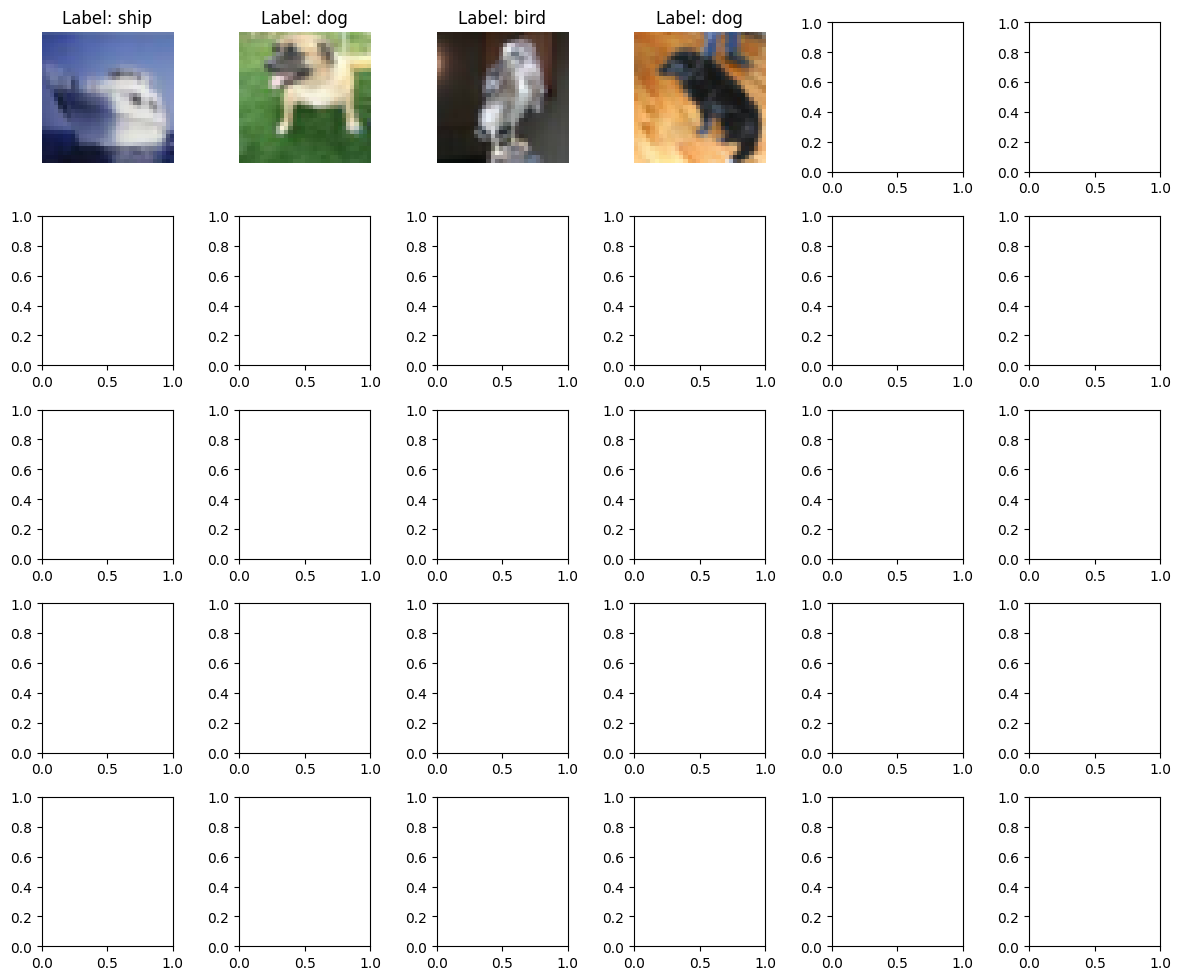

In [ ]:
import random

test_images_all = []
test_labels_all = []

for images, labels in testloader:
    test_images_all.append(images)
    test_labels_all.extend(labels)
    
    if len(test_labels_all) >= 30:
        break

test_images = torch.cat(test_images_all)[:30]
test_labels = torch.tensor(test_labels_all[:30])

indices = random.sample(range(len(test_images)), 30)
selected_images = test_images[indices]
selected_labels = test_labels[indices]

best_layers = [
    {"entry": 3, "out": 128, "kernel_size": 5}
]
for _ in range(4 - 1):
    best_layers.append({"entry": 128, "out": 128, "kernel_size": 5})

model = custom_net(lerning_late=0.00013353402447959808, layers=best_layers, num_epochs=10)

model.eval()
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(5, 6, figsize=(12, 10))
axes = axes.flatten()
for idx, (img, true_label, pred_label) in enumerate(zip(selected_images, selected_labels, predicted)):
    img = img / 2 + 0.5
    img = img.numpy().transpose((1, 2, 0))
    axes[idx].imshow(img)
    axes[idx].set_title(f'True: {classes[true_label]} \nPred: {classes[pred_label]}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()